- http://keunwoochoi.blogspot.com/2016/03/2.html
- http://www.rex-ai.info/docs/AI_Example_CNN_speech_recognize
- https://www.youtube.com/watch?v=oltGIc4uo5c
- https://youdaeng-com.tistory.com/5

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
from torchvision import transforms, datasets
import pandas as pd
import os
from glob import glob
import torchvision.models as models
import sys
from pytorchtools.pytorchtools import EarlyStopping # 현재 폴더에 추가된 모듈.


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [2]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

# 데이터 나누기
- pathology : 852 ,  healthy 수 :  632  총 1484
- train :  1187 , test : 297

## 1. test/ train 나누기


In [3]:
#1. train, test 나누기

import os
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split # train , test 분리에 사용.


pathology = glob('../voice_data/fusion/pathology/phrase/*.wav')
healthy = glob('../voice_data/fusion/pathology/phrase/*.wav')
print("Pathology : ",len(pathology))
print("Healthy: ",len(healthy))


pathology= [ path.split("\\")[-1] for path in pathology] # path 데이터 변환.
healthy= [ path.split("\\")[-1] for path in healthy] # path 데이터 변환.
 # path 데이터 변환


X = pathology+healthy # path 데이터 합
print("총 데이터수 : ",len(X))
Y = [] # 라벨
for idx,x in enumerate(X):
    if idx<1193:
        Y.append("pathology")
    else:
        Y.append("healthy")

X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y, random_state=456)
#stratify를 넣어서, test에도 라벨별 잘 분류되게 한다.

print("---")
print("훈련 셋 : ",len(Y),Counter(Y))
print("테스트 셋 : ",len(Y_test),Counter(Y_test))
print("---")

Pathology :  1193
Healthy:  1193
총 데이터수 :  2386
---
훈련 셋 :  1908 Counter({'pathology': 954, 'healthy': 954})
테스트 셋 :  478 Counter({'healthy': 239, 'pathology': 239})
---


## 2. stratified k-fold

In [4]:
#1. train, test 나누기
#stratified kfold
import os
import random #데이터 shuffle 사용
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter



skf_iris = StratifiedKFold(n_splits=5,shuffle=True,random_state=456)
cnt_iter = 0

X_train_list = [] #데이터 셋 보관
Y_train_list = []

X_valid_list = []
Y_valid_list = []

for train_idx, test_idx in skf_iris.split(X,Y):
    
    #split으로 반환된 인덱스를 이용하여, 학습 검증용 테스트 데이터 추출
    cnt_iter += 1
    X_train, X_valid = [X[idx] for idx in train_idx.tolist() ], [X[idx] for idx in test_idx.tolist() ]
    Y_train, Y_valid = [Y[idx] for idx in train_idx.tolist() ], [Y[idx] for idx in test_idx.tolist() ]
    
    X_train_list.append(X_train)
    X_valid_list.append(X_valid)
    
    Y_train_list.append(Y_train)
    Y_valid_list.append(Y_valid)
    
    
    #학습 및 예측
    
    label_train = Y_train
    label_test = Y_valid
    unique_train, train_counts = np.unique(label_train, return_counts = True)
    unique_test, test_counts = np.unique(label_test, return_counts = True)
    
    uniq_cnt_train = dict(zip(unique_train, train_counts))
    uniq_cnt_test = dict(zip(unique_test, test_counts))
    
    
    
    print('교차 검증 : {}'.format(cnt_iter))
    print('학습 레이블 데이터 분포 : \n', uniq_cnt_train)
    print('검증 레이블 데이터 분포 : \n', uniq_cnt_test,'\n')



교차 검증 : 1
학습 레이블 데이터 분포 : 
 {'healthy': 763, 'pathology': 763}
검증 레이블 데이터 분포 : 
 {'healthy': 191, 'pathology': 191} 

교차 검증 : 2
학습 레이블 데이터 분포 : 
 {'healthy': 763, 'pathology': 763}
검증 레이블 데이터 분포 : 
 {'healthy': 191, 'pathology': 191} 

교차 검증 : 3
학습 레이블 데이터 분포 : 
 {'healthy': 763, 'pathology': 763}
검증 레이블 데이터 분포 : 
 {'healthy': 191, 'pathology': 191} 

교차 검증 : 4
학습 레이블 데이터 분포 : 
 {'healthy': 764, 'pathology': 763}
검증 레이블 데이터 분포 : 
 {'healthy': 190, 'pathology': 191} 

교차 검증 : 5
학습 레이블 데이터 분포 : 
 {'healthy': 763, 'pathology': 764}
검증 레이블 데이터 분포 : 
 {'healthy': 191, 'pathology': 190} 



## 3. random over sampling

In [5]:
#2. random over sampling
for i in range(5):
    X_temp = np.array(X_train_list[i]).reshape(-1,1)#각 데이터를 다 행으로 넣음. (1194,1)
    #Y = np.array(Y)
    ros = RandomOverSampler(random_state = 123)
    X_res,Y_res = ros.fit_resample(X_temp,Y_train_list[i])
    
    print("\n fold{} ".format(i))
    print('before dataset shape {}'.format(Counter(Y_train_list[i])) )
    print('Resampled dataset shape {}'.format(Counter(Y_res)) )
    
    #원래대로 돌리기
    X_res=X_res.reshape(1, -1)
    X_train_list[i]=X_res[0].tolist()
    Y_train_list[i]=Y_res




 fold0 
before dataset shape Counter({'healthy': 763, 'pathology': 763})
Resampled dataset shape Counter({'healthy': 763, 'pathology': 763})

 fold1 
before dataset shape Counter({'pathology': 763, 'healthy': 763})
Resampled dataset shape Counter({'pathology': 763, 'healthy': 763})

 fold2 
before dataset shape Counter({'pathology': 763, 'healthy': 763})
Resampled dataset shape Counter({'pathology': 763, 'healthy': 763})

 fold3 
before dataset shape Counter({'healthy': 764, 'pathology': 763})
Resampled dataset shape Counter({'pathology': 764, 'healthy': 764})

 fold4 
before dataset shape Counter({'pathology': 764, 'healthy': 763})
Resampled dataset shape Counter({'pathology': 764, 'healthy': 764})


## 4. 데이터 미리 읽기

In [6]:
import pickle

 
#load
with open("../voice_data/fusion/phrase_dict.pickle","rb") as fr:
    phrase_dict = pickle.load(fr)


#load
with open("../voice_data/fusion/a_dict.pickle","rb") as fr:
    a_dict = pickle.load(fr)
    
    
    

# 데이터 정의
- 추가적으로 데이터의 크기를 맞춰주기 위해 3초로 padding 및 truncate 실시 https://sequencedata.tistory.com/25 FixAudioLength
- 논문에서는 400frame으로 설정.(여기서는 500frame)
- 전처리 방법 결정.
- 속도를 높히기 위해 미리 데이터 전처리.


In [15]:
from torch.utils.data import Dataset, DataLoader

classes = ["pathology","healthy"]
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.



class svd_dataset(Dataset):
    def __init__(self,data_path_list,classes,data_num,training,transform=None,transform2=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list[data_num]
        self.data_num = data_num
        self.training = training
        self.label = svd_dataset.get_label(self.path_list,training,data_num)
        self.classes=classes
        self.transform=transform
        self.transform2=transform2
        
    
    @classmethod
    def get_label(cls,data_path_list,training,data_num):
        label_list=[]
        
        if training:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_train_list[data_num][idx])
        else:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_valid_list[data_num][idx])
        #print(label_list)
        return label_list
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다.     
        
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc, spectro, mel-spectro를 추출
        2. mfcc를 300프레임으로 패딩. 또한 세로축은 128으로 interpolate
        3. resnet에 사용되기 위해 3채널로 쌓기.
        4. 미정. 0~1 정규화
        
        """

        log_spectrogram=phrase_dict[self.path_list[idx]][0]
        mel_feature = phrase_dict[self.path_list[idx]][1]
        MFCCs = phrase_dict[self.path_list[idx]][2]
        
        if self.transform:
            #print('transform')
            log_spectrogram=self.transform(log_spectrogram).type(torch.float32)# 타입 변화
            mel_feature=self.transform(mel_feature).type(torch.float32)# 타입 변화
            MFCCs=self.transform(MFCCs).type(torch.float32)# 타입 변화           
            MSF = self.transform2(torch.stack([log_spectrogram,mel_feature,MFCCs]).squeeze(1))# 3채널로 복사.
        else:
            #print("else")
            ##################안쓰는 곳
            log_spectrogram = torch.from_numpy(log_spectrogram).type(torch.float32)
            log_spectrogram=log_spectrogram.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return MSF, self.classes.index(self.label[idx])
    

In [16]:
# test set 제작을 위한 class
class svd_test_set(Dataset):
    def __init__(self,data_path_list,classes,transform=None,transform2=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list
        self.label = svd_test_set.get_label(self.path_list)
        self.classes=classes
        self.transform=transform
        self.transform2=transform2
        
    
    @classmethod
    def get_label(cls,data_path_list):
        label_list=[]
        
        for idx,x in enumerate(data_path_list):
            label_list.append(Y_test[idx])
        #print(label_list)
        return label_list
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다. 
        
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc, spectro, mel-spectro를 추출
        2. mfcc를 300프레임으로 패딩. 또한 세로축은 128으로 interpolate
        3. resnet에 사용되기 위해 3채널로 쌓기.
        4. 미정. 0~1 정규화
        
        """

        log_spectrogram=phrase_dict[self.path_list[idx]][0]
        mel_feature = phrase_dict[self.path_list[idx]][1]
        MFCCs = phrase_dict[self.path_list[idx]][2]
        
        if self.transform:
            #print('transform')
            log_spectrogram=self.transform(log_spectrogram).type(torch.float32)# 타입 변화
            mel_feature=self.transform(mel_feature).type(torch.float32)# 타입 변화
            MFCCs=self.transform(MFCCs).type(torch.float32)# 타입 변화 
            MSF = self.transform2(torch.stack([log_spectrogram,mel_feature,MFCCs]).squeeze(dim=1))# 3채널로 복사.
        else:
            #print("else")
            ##################안쓰는 곳
            log_spectrogram = torch.from_numpy(log_spectrogram).type(torch.float32)
            log_spectrogram=log_spectrogram.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return MSF, self.classes.index(self.label[idx])
    
    

# 데이터 로더

In [17]:
#3. 하이퍼 파라미터
BATCH_SIZE =  32 #한 배치당 32개 음성데이터
EPOCHS = 50 # 전체 데이터 셋을 50번 반복

In [18]:
#DATA LOADER 함수가 BATCH_size 단위로 분리해 지정.

#확인을 위해 데이터셋 하나만 확인



train_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_train_list,
                                               classes,
                                               transform=transforms.ToTensor(),
                                               transform2=transforms.Resize((224, 224)),
                                               data_num=0,
                                               training=True
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,
                                           ) # 순서가 암기되는것을 막기위해.

validation_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_valid_list,
                                               classes,
                                               transform=transforms.ToTensor(),
                                               transform2=transforms.Resize((224, 224)),
                                               data_num=0,
                                               training=False
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,) 



In [19]:
# 테스트 데이터 로더.

test_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_test_set(
                                                   X_test,
                                                   classes,
                                               transform=transforms.ToTensor(),
                                               transform2=transforms.Resize((224, 224)),
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,) 

# 데이터 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


X_train :  torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
Y_train :  torch.Size([32]) type: torch.LongTensor
tensor(0)


Text(0.5, 1.0, 'Spectrogram (dB)')

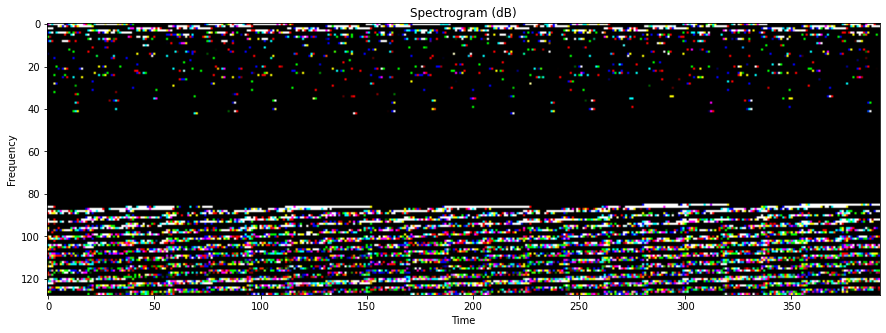

In [20]:
# 4. 데이터 확인하기
for (X_train,Y_train) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break
    
print(Y_train[0])
plt.figure(figsize=(15,5))
plt.imshow(X_train[0].view(128,-1,3)[:,:,].numpy())
plt.xlabel("Time")
plt.ylabel("Frequency")
#plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")
#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


X_valid :  torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
Y_valid :  torch.Size([32]) type: torch.LongTensor
tensor(0)


Text(0.5, 1.0, 'Spectrogram (dB)')

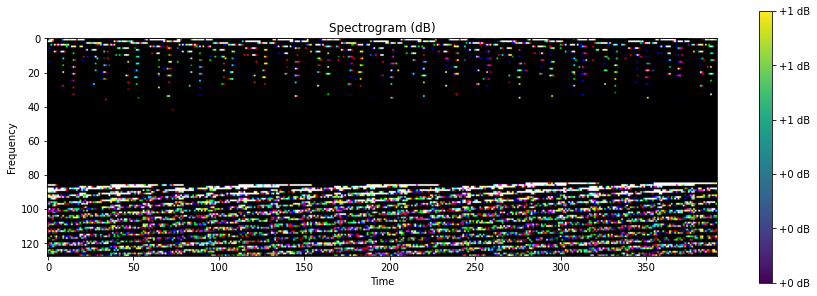

In [21]:
#valiation set 확인
for (X_valid,Y_valid) in validation_loader:
    print("X_valid : ",X_valid.size(),'type:',X_valid.type())
    print("Y_valid : ",Y_valid.size(),'type:',Y_valid.type())
    break

print(Y_valid[0])
plt.figure(figsize=(15,5))
plt.imshow(X_valid[0].view(128,-1,3).numpy())
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


X_valid :  torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
Y_valid :  torch.Size([32]) type: torch.LongTensor
tensor(1)


Text(0.5, 1.0, 'Spectrogram (dB)')

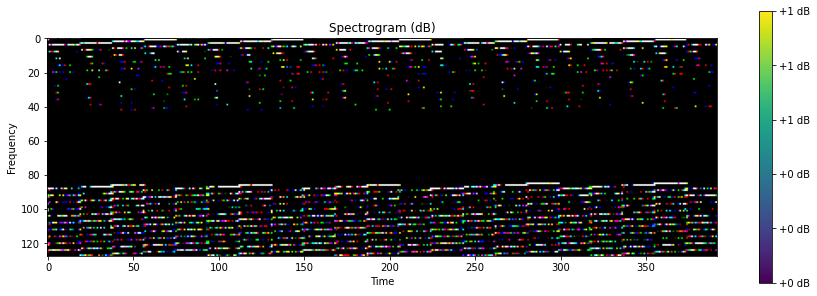

In [22]:
#test set 확인
for (test_data,test_label) in test_loader:
    print("X_valid : ",test_data.size(),'type:',test_data.type())
    print("Y_valid : ",test_label.size(),'type:',test_label.type())
    break

print(test_label[0])
plt.figure(figsize=(15,5))
plt.imshow(test_data[0].view(128,-1,3).numpy())
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

# LSTM

- https://wikidocs.net/60762
- https://sanghyu.tistory.com/52

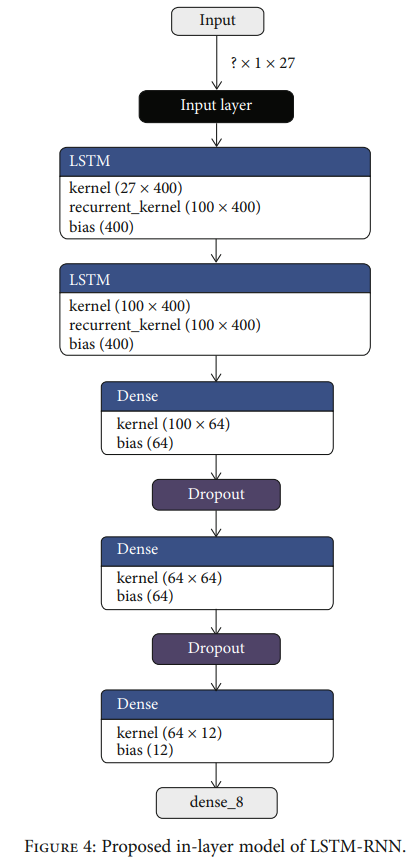

```
model = Sequential()
model.add(LSTM(hidden_unit = 100, input_shape=(time_steps=100, input_dim=27)))
마지막 히든레이어가 100인것으로 보아, 마지막 시점 데이터를 사용한 것으로
#hidden_unit : 은닉층의 output_dim 
#time_steps: frame 수(시점의 수)
#input_dim: 27
# 100: timestamp 수, 400:hidden layer의 총파라미터 수 (hidden_unit * 4)
# 100 x 400
```

- cnn에 삽입해서 그 node를 삽입할 생각이다.
- 그리고 이게 몇 패딩이었는지 외우고 있어야 할텐데

In [ ]:
X_train.size()

In [ ]:
X_train[:,:,:,:].size()

- https://coding-yoon.tistory.com/58 bidirectional

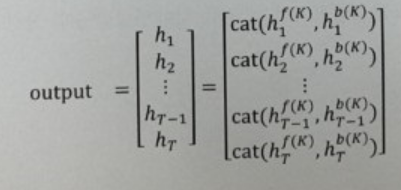

In [ ]:
input_size1 = 128
hidden_size1 =1
num_layers=10

input_data=X_train[:,0].permute(0,2,1)
print('input : ',input_data.size())
lstm1 = nn.LSTM(input_size=input_size1, hidden_size=hidden_size1,num_layers=num_layers, batch_first = True,bidirectional=True)

data,_=lstm1(input_data)# (모든 hidden, 최종 hidden)
print(data.size())
sample_fc=nn.Linear(600,2)
sample_fc(data.reshape(-1,600))
#input_data=data[0].permute(1,0,2) #출력될때 batch랑 순서가 바꿔서 나와서.
#print('lstm1 output : ',input_data.size())

#print('lstm1 output : ',input_data)

In [ ]:
X_train[:,0].permute(0,2,1).size()

testmodel=nn.Conv2d(
                in_channels = 3,
                out_channels = 64,
                kernel_size = (128,1)
            )
# torch.Size([32, 64, 1, 300])
testmodel2=nn.Conv2d(
                in_channels = 64,
                out_channels = 128,
                kernel_size = (1,151)
            )
# torch.Size([32, 128, 1, 150])
testmodel3=nn.Conv2d(
                in_channels = 128,
                out_channels = 1,
                kernel_size = (1,23)
            )         
# torch.Size([32, 1, 1, 128])
dat1=testmodel(X_train[:,:,:,:])
dat2=testmodel2(dat1)
print(dat2.size())
dat3=testmodel3(dat2)
dat3.size()

In [23]:
input_size1 = 1 # node가 512 time step ,1 차원데이터
hidden_size1 = 2 # 마지막 출력은 2 class ->bidirectional은 2배
num_layers=1 # 1 레이어 lstm




class Net(nn.Module):
    def __init__(self,n_class=2):
        super(Net,self).__init__() # 상속받기
        self.lstm1 = nn.LSTM(input_size=input_size1,
                             hidden_size=hidden_size1,
                             num_layers=num_layers,
                             batch_first = True,
                             bidirectional=False,
                             bias=True)
        self.res_model = models.resnet18(pretrained=True)
        self.res_model.ftrs = self.res_model.fc.in_features # in_features : fully connected의 입력수.
        num_ftrs = self.res_model.fc.in_features
        self.res_model=torch.nn.Sequential(*(list(self.res_model.children())[:-1]))


        
    
    def forward(self,x):
        data=self.res_model(x)
        data=data.squeeze(2)
        data,_=self.lstm1(data) # (output, 최종 hidden)
        x=data[:,-1,:].squeeze()
        return x

In [ ]:
input_size1 = 1 # node가 512,1 차원
hidden_size1 = 1 # 마지막 출력은 2 class ->bidirecional 은 4개
num_layers=1 # 1 레이어 lstm




class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__() # 상속받기
        self.lstm1 = nn.LSTM(input_size=input_size1,
                             hidden_size=hidden_size1,
                             num_layers=num_layers,
                             batch_first = True,
                             bidirectional=True,
                             bias=True)
        self.res_model = models.resnet18(pretrained=True)
        self.res_model.ftrs = self.res_model.fc.in_features # in_features : fully connected의 입력수.
        num_ftrs = self.res_model.fc.in_features
        self.res_model=torch.nn.Sequential(*(list(self.res_model.children())[:-1])) 
        
        self.fc = nn.Sequential(nn.Linear(4,2),
                               )
        
        
        
    
    def forward(self,x):
        data=self.res_model(x)
        data=data.squeeze(2)
        data,_=self.lstm1(data) # (output, 최종 hidden)
        
        data_1=data[:,-1,:].squeeze()
        data_2=data[:,1,:].squeeze()
        x=torch.cat((data_2,data_1),1)
        x=self.fc(x)
        return x

In [ ]:
##### 자체제작 CNN 모델과 LSTM

input_size1 = 1 # node가 512 time step ,1 차원데이터
hidden_size1 = 2 # 마지막 출력은 2 class ->bidirectional은 2배
num_layers=1 # 1 레이어 lstm


class frequency_net(nn.Module):
    def __init__(self):
        super(frequency_net,self).__init__() # 상속받기
        self.model = nn.Sequential(
            nn.Conv2d(
                in_channels = 3,
                out_channels = 64,
                kernel_size = (128,1)
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        # torch.Size([32, 64, 1, 300])
        nn.Conv2d(
                in_channels = 64,
                out_channels = 128,
                kernel_size = (1,151)
            ),
# torch.Size([32, 128, 1, 150])
            nn.BatchNorm2d(128),
            nn.ReLU(),
         nn.Conv2d(
                in_channels = 128,
                out_channels = 1,
                kernel_size = (1,23)
            ),         
# torch.Size([32, 1, 1, 128])
        )
        

        
    
    def forward(self,x):
        x=self.model(x).permute(0,1,3,2)
        return x    





class Net(nn.Module):
    def __init__(self,n_class=2):
        super(Net,self).__init__() # 상속받기
        self.lstm1 = nn.LSTM(input_size=input_size1,
                             hidden_size=hidden_size1,
                             num_layers=num_layers,
                             batch_first = True,
                             bidirectional=False,
                             bias=True)
        self.cnn_model = frequency_net()

        
    
    def forward(self,x):
        data=self.cnn_model(x)
        data=data.squeeze(1)
        data,_=self.lstm1(data) # (output, 최종 hidden)
        x=data[:,-1,:].squeeze()
        return x


In [24]:
#7. Optimizer, Objective Function
model = Net()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()
#원핫 인코딩값의 loss는 crossEntropyLoss로 비교
print(model)

Net(
  (lstm1): LSTM(1, 2, batch_first=True)
  (res_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, 

In [25]:
#7. Optimizer, Objective Function
def model_initialize():
    model = Net().to(DEVICE)
    #원핫 인코딩값의 loss는 crossEntropyLoss로 비교
    #print(model)
    return model

In [26]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx,(image,label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        output = model(image) # model로 output을 계산
        loss = criterion(output, label) #loss 계산
        train_loss += loss.item()
        prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
        correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
        loss.backward() # loss 값을 이용해 gradient를 계산
        optimizer.step() # Gradient 값을 이용해 파라미터 업데이트.
    train_loss/=len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss,train_accuracy


In [27]:
#9. 학습 진행하며, validation 데이터로 모델 성능확인
def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in valid_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            valid_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
            #true.false값을 sum해줌. item
        valid_loss /= len(valid_loader.dataset)
        valid_accuracy = 100. * correct / len(valid_loader.dataset)
        return valid_loss,valid_accuracy


In [28]:
#데이터 로더 제작 함수

def load_data(data_ind):

    train_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_train_list,
                                                   classes,
                                               transform=transforms.ToTensor(),
                                               transform2=transforms.Resize((224, 224)),
                                                   data_num=data_ind,
                                                   training=True
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,
                                               ) # 순서가 암기되는것을 막기위해.

    validation_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_valid_list,
                                                   classes,
                                               transform=transforms.ToTensor(),
                                               transform2=transforms.Resize((224, 224)),
                                                   data_num=data_ind,
                                                   training=False
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,) 
    return train_loader,validation_loader



In [29]:
#10. 학습 및 평가.
# resnet34 pretrained true
# kfold 적용

train_accs = []
valid_accs = []

for data_ind in range(1,6):

    check_path = './checkpoint/checkpoint_msf_resnet18_true_ros_'+str(data_ind)+'lstm_RESIZE.pt'
    print(check_path)
    early_stopping = EarlyStopping(patience = 10, verbose = True, path=check_path)
    train_loader,validation_loader = load_data(data_ind-1)
    
    best_train_acc=0 # accuracy 기록용
    best_valid_acc=0
    
    model=model_initialize()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
    
    
    print("[{} 교차검증] 학습 시작\n ----- ".format(data_ind))
    for Epoch in range(1,EPOCHS+1):
        train_loss,train_accuracy=train(model,train_loader,optimizer,log_interval=31)
        valid_loss,valid_accuracy = evaluate(model, validation_loader)


        print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train Acc:{:.2f} %  | \tValid Loss:{:.4f} \tValid Acc: {:.2f} %\n".
              format(Epoch,train_loss,train_accuracy,valid_loss,valid_accuracy))
        

        early_stopping(valid_loss, model)
        if -early_stopping.best_score == valid_loss:
            best_train_acc, best_valid_acc = train_accuracy,valid_accuracy
        
        if early_stopping.early_stop:
                train_accs.append(best_train_acc)
                valid_accs.append(best_valid_acc)
                print("[{} 교차검증] Early stopping".format(data_ind))
                break

        if Epoch==EPOCHS:
            #만약 early stop 없이 40 epoch라서 중지 된 경우.
            train_accs.append(best_train_acc)
            valid_accs.append(best_valid_acc)

./checkpoint/checkpoint_msf_resnet18_true_ros_1lstm_RESIZE.pt
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0219	 Train Acc:50.00 %  | 	Valid Loss:0.0218 	Valid Acc: 50.00 %

Validation loss decreased (inf --> 0.021830).  Saving model ...

[EPOCH:2]	 Train Loss:0.0218	 Train Acc:50.00 %  | 	Valid Loss:0.0218 	Valid Acc: 50.00 %

EarlyStopping counter: 1 out of 10

[EPOCH:3]	 Train Loss:0.0219	 Train Acc:50.00 %  | 	Valid Loss:0.0219 	Valid Acc: 50.00 %

EarlyStopping counter: 2 out of 10

[EPOCH:4]	 Train Loss:0.0218	 Train Acc:50.00 %  | 	Valid Loss:0.0218 	Valid Acc: 50.00 %

EarlyStopping counter: 3 out of 10

[EPOCH:5]	 Train Loss:0.0218	 Train Acc:50.00 %  | 	Valid Loss:0.0219 	Valid Acc: 50.00 %

EarlyStopping counter: 4 out of 10

[EPOCH:6]	 Train Loss:0.0218	 Train Acc:50.00 %  | 	Valid Loss:0.0219 	Valid Acc: 50.00 %

EarlyStopping counter: 5 out of 10


KeyboardInterrupt: 

In [ ]:
#10. 학습 및 평가.
# resnet34 pretrained true
# kfold 적용

train_accs = []
valid_accs = []

for data_ind in range(1,6):

    check_path = './checkpoint/checkpoint_msf_resnet18_true_ros_'+str(data_ind)+'lstm_1_norm.pt'
    print(check_path)
    early_stopping = EarlyStopping(patience = 10, verbose = True, path=check_path)
    train_loader,validation_loader = load_data(data_ind-1)
    
    best_train_acc=0 # accuracy 기록용
    best_valid_acc=0
    
    model=model_initialize()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
    
    
    print("[{} 교차검증] 학습 시작\n ----- ".format(data_ind))
    for Epoch in range(1,EPOCHS+1):
        train_loss,train_accuracy=train(model,train_loader,optimizer,log_interval=31)
        valid_loss,valid_accuracy = evaluate(model, validation_loader)


        print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train Acc:{:.2f} %  | \tValid Loss:{:.4f} \tValid Acc: {:.2f} %\n".
              format(Epoch,train_loss,train_accuracy,valid_loss,valid_accuracy))
        

        early_stopping(valid_loss, model)
        if -early_stopping.best_score == valid_loss:
            best_train_acc, best_valid_acc = train_accuracy,valid_accuracy
        
        if early_stopping.early_stop:
                train_accs.append(best_train_acc)
                valid_accs.append(best_valid_acc)
                print("[{} 교차검증] Early stopping".format(data_ind))
                break

        if Epoch==EPOCHS:
            #만약 early stop 없이 40 epoch라서 중지 된 경우.
            train_accs.append(best_train_acc)
            valid_accs.append(best_valid_acc)

In [ ]:
#10. 학습 및 평가.
# resnet34 pretrained true
# kfold 적용

train_accs = []
valid_accs = []

for data_ind in range(1,6):

    check_path = './checkpoint/checkpoint_msf_frequency_true_ros_'+str(data_ind)+'lstm_1_norm.pt'
    print(check_path)
    early_stopping = EarlyStopping(patience = 10, verbose = True, path=check_path)
    train_loader,validation_loader = load_data(data_ind-1)
    
    best_train_acc=0 # accuracy 기록용
    best_valid_acc=0
    
    model=model_initialize()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
    
    
    print("[{} 교차검증] 학습 시작\n ----- ".format(data_ind))
    for Epoch in range(1,EPOCHS+1):
        train_loss,train_accuracy=train(model,train_loader,optimizer,log_interval=31)
        valid_loss,valid_accuracy = evaluate(model, validation_loader)


        print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train Acc:{:.2f} %  | \tValid Loss:{:.4f} \tValid Acc: {:.2f} %\n".
              format(Epoch,train_loss,train_accuracy,valid_loss,valid_accuracy))
        

        early_stopping(valid_loss, model)
        if -early_stopping.best_score == valid_loss:
            best_train_acc, best_valid_acc = train_accuracy,valid_accuracy
        
        if early_stopping.early_stop:
                train_accs.append(best_train_acc)
                valid_accs.append(best_valid_acc)
                print("[{} 교차검증] Early stopping".format(data_ind))
                break

        if Epoch==EPOCHS:
            #만약 early stop 없이 40 epoch라서 중지 된 경우.
            train_accs.append(best_train_acc)
            valid_accs.append(best_valid_acc)

In [ ]:
#10. 학습 및 평가.
# resnet34 pretrained true
# kfold 적용
#bidirectional

train_accs = []
valid_accs = []

for data_ind in range(1,6):

    check_path = './checkpoint/checkpoint_msf_resnet18_true_ros_'+str(data_ind)+'_lstm_1_true.pt'
    print(check_path)
    early_stopping = EarlyStopping(patience = 10, verbose = True, path=check_path)
    train_loader,validation_loader = load_data(data_ind-1)
    
    best_train_acc=0 # accuracy 기록용
    best_valid_acc=0
    
    model=model_initialize()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
    
    
    print("[{} 교차검증] 학습 시작\n ----- ".format(data_ind))
    for Epoch in range(1,EPOCHS+1):
        train_loss,train_accuracy=train(model,train_loader,optimizer,log_interval=31)
        valid_loss,valid_accuracy = evaluate(model, validation_loader)


        print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train Acc:{:.2f} %  | \tValid Loss:{:.4f} \tValid Acc: {:.2f} %\n".
              format(Epoch,train_loss,train_accuracy,valid_loss,valid_accuracy))
        

        early_stopping(valid_loss, model)
        if -early_stopping.best_score == valid_loss:
            best_train_acc, best_valid_acc = train_accuracy,valid_accuracy
        
        if early_stopping.early_stop:
                train_accs.append(best_train_acc)
                valid_accs.append(best_valid_acc)
                print("[{} 교차검증] Early stopping".format(data_ind))
                break

        if Epoch==EPOCHS:
            #만약 early stop 없이 40 epoch라서 중지 된 경우.
            train_accs.append(best_train_acc)
            valid_accs.append(best_valid_acc)

In [ ]:
sum_valid=0
for data_ind in range(5):
    print("[{} 교차검증] train ACC : {:.4f} |\t valid ACC: {:.4f} ".format(data_ind+1,train_accs[data_ind],valid_accs[data_ind] ))
    sum_valid+=valid_accs[data_ind]
    
print("평균 검증 정확도",sum_valid/5,"%")

In [ ]:
sum_valid=0
for data_ind in range(5):
    print("[{} 교차검증] train ACC : {:.4f} |\t valid ACC: {:.4f} ".format(data_ind+1,train_accs[data_ind],valid_accs[data_ind] ))
    sum_valid+=valid_accs[data_ind]
    
print("평균 검증 정확도",sum_valid/5,"%")

# Model Test

- test set
- confusion matrix

In [ ]:
#9. 학습 진행하며, validation 데이터로 모델 성능확인
def test_evaluate(model,test_loader):
    model.eval()
    predictions = []
    answers = []
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            output = F.softmax(output, dim=1).data.squeeze() # softmax 적용 (모델을 통과는 했지만, criterion는 안통과함.)
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            answers +=label
            predictions +=prediction
        return predictions,answers

In [2]:
# Confusion matrix (resnet18)
# kfold의 confusion matrix는 계산 방법이 다르다.
# 모델을 각각 불러와서 test set을 평가한다.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

cf = np.zeros((2,2))
cf_list = []
average_accuracy = 0
average_fscore = 0

for data_ind in range(1,6):

    check_path = './checkpoint/checkpoint_msf_resnet18_true_ros_'+str(data_ind)+'lstm_1_norm.pt'
    model.load_state_dict(torch.load(check_path))

    predictions,answers = test_evaluate(model, test_loader)
    predictions=[ dat.cpu().numpy() for dat in predictions]
    answers=[ dat.cpu().numpy() for dat in answers]

    
    cf = confusion_matrix(answers, predictions)
    cf_list.append(cf)
    
    acc = (cf[0,0]+cf[1,1])/(cf[0,0]+cf[0,1]+cf[1,0]+cf[1,1])
    average_accuracy+=acc
    precision=cf[0,0]/(cf[0,0]+cf[1,0])
    recall=cf[0,0]/(cf[0,0]+cf[0,1])
    #fscore=2*precision*recall/(precision+recall)
    
    #fscroe macro추가
    fscore = f1_score(answers,predictions,average='macro')
    average_fscore+=fscore
    
    print('{}번 모델'.format(data_ind))
    print("Accuracy : {:.4f}% ".format(acc*100))
    print("Precision (pathology 예측한 것중 맞는 것) : {:.4f}".format(precision))
    print("recall (실제 pathology 중  예측이 맞는 것) : {:.4f}".format(recall))
    print("f score : {:.4f} ".format(fscore))
    print(cf)
    print("-----")

print("평균 acc : {:.4f}".format(average_accuracy/5))
print("평균 f1score : {:.4f}".format(average_fscore/5))




NameError: name 'np' is not defined

In [ ]:
# Confusion matrix (resnet18)
# kfold의 confusion matrix는 계산 방법이 다르다.
# 모델을 각각 불러와서 test set을 평가한다.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

cf = np.zeros((2,2))
cf_list = []
average_accuracy = 0
average_fscore = 0

for data_ind in range(1,6):

    check_path = './checkpoint/checkpoint_msf_resnet18_true_ros_'+str(data_ind)+'lstm_1.pt'
    model.load_state_dict(torch.load(check_path))

    predictions,answers = test_evaluate(model, test_loader)
    predictions=[ dat.cpu().numpy() for dat in predictions]
    answers=[ dat.cpu().numpy() for dat in answers]

    
    cf = confusion_matrix(answers, predictions)
    cf_list.append(cf)
    
    acc = (cf[0,0]+cf[1,1])/(cf[0,0]+cf[0,1]+cf[1,0]+cf[1,1])
    average_accuracy+=acc
    precision=cf[0,0]/(cf[0,0]+cf[1,0])
    recall=cf[0,0]/(cf[0,0]+cf[0,1])
    #fscore=2*precision*recall/(precision+recall)
    
    #fscroe macro추가
    fscore = f1_score(answers,predictions,average='macro')
    average_fscore+=fscore
    
    print('{}번 모델'.format(data_ind))
    print("Accuracy : {:.4f}% ".format(acc*100))
    print("Precision (pathology 예측한 것중 맞는 것) : {:.4f}".format(precision))
    print("recall (실제 pathology 중  예측이 맞는 것) : {:.4f}".format(recall))
    print("f score : {:.4f} ".format(fscore))
    print(cf)
    print("-----")

print("평균 acc : {:.4f}".format(average_accuracy/5))
print("평균 f1score : {:.4f}".format(average_fscore/5))